# New York City taxi Fare Case Study
In this problem are tasked with predicting the fare amount for a taxi ride in New York City given the pickup and dropoff cpLocations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of 5 to 8 dollars, depending on the model used.

- This dataset with about 55 million records. *The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers.*

- It is up to you to extract any further information. For instance, **does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?**

For this data we've whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. **The records are randomly sorted.**

**HINT: you can calculate distance from GPS coordinates, and you should create a pandas datatime object from a text column. This will let you quickly get information like day of the week, am vs. pm, etc.**

## Attributes
- **fare_amount** - float for the fare amount collected at this ride.
- **fare_class** - integer for determining the class of the fare 0 or 1.
- **pickup_datetime** - timestamp value indicating when the taxi ride started.
- **pickup_longitude** - float for longitude coordinate of where the taxi ride started.
- **pickup_latitude** - float for latitude coordinate of where the taxi ride started.
- **dropoff_longitude** - float for longitude coordinate of where the taxi ride ended.
- **dropoff_latitude** - float for latitude coordinate of where the taxi ride ended.
- **passenger_count** - integer indicating the number of passengers in the taxi ride.

In [2]:
#Adding important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

from tabulate import tabulate


## Exploring the data

In [3]:
df = pd.read_csv("NYCTaxiFares.csv") #Reading the dataset in a dataframe using Pandas

In [4]:
df.info() #Seeing the number and type of data in each column in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


In [5]:
df.head() #Seeing the first five rows of test data for exploration

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [6]:
df['fare_class'].value_counts() #Displaying number of classes and its values in the fare_class column 

0    80000
1    40000
Name: fare_class, dtype: int64

In [7]:
df.isnull().sum() #Looking for the numbers of null values in each column

pickup_datetime      0
fare_amount          0
fare_class           0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
df.duplicated().sum() #Looking for any DuPlicated rows in the data frame to remove it

0

- There is no duplicate rows in the dataset

In [9]:
df.describe() # get the summary of numerical variables in the  dataset

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,10.040326,0.333333,-73.976626,40.751443,-73.974501,40.751695,1.347167
std,7.500134,0.471406,0.031497,0.025821,0.032419,0.030279,0.759263
min,2.500000,0.000000,-74.465447,40.121653,-74.443323,40.164927,1.000000
25%,5.700000,0.000000,-73.992386,40.736594,-73.991478,40.735914,1.000000
50%,7.700000,0.000000,-73.982084,40.753661,-73.980411,40.754441,1.000000
75%,11.300000,1.000000,-73.968710,40.768020,-73.965500,40.768880,1.000000
max,49.900000,1.000000,-73.311845,40.981292,-73.496140,40.993498,5.000000


## Data Manipulation

Here we found that:
1. The time is in UTC format, So we need to convert it to US zone timing.
2. We only need hour and the weekday parts of the **pickup_datetime** column(because the datasetrecords from April 11 to April 24, 2010) 
3. We can calculate the distance travelled in a ride using the **pickup_longitude**, **pickup_latitude**, **dropoff_longitude**, **dropoff_latitude**.
4. We need to drop the **pickup_datatime** column as it is a str object and will be only overhead for the model.

In [10]:
#Time is in UTC which is 4 hrs ahead of US Time
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime']) - pd.Timedelta(hours=4) #Converting time to US time
#Splitting the pickup_datetime to hour & weekday attributes
df['Hour']=df['pickup_datetime'].dt.hour #extracting the hour from the pickup_datetime column into an external column
df['Weekday']=df['pickup_datetime'].dt.strftime('%a') #extracting the weekday from the pickup_datetime column into an external column

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Weekday
0,2010-04-19 04:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,4,Mon
1,2010-04-17 11:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,11,Sat
2,2010-04-17 07:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,7,Sat
3,2010-04-11 17:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,17,Sun
4,2010-04-16 22:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,22,Fri


# Distance Eq

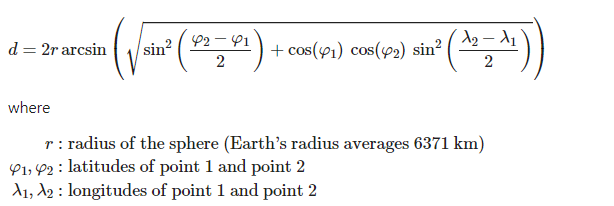


In [11]:
# The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.
#Important in navigation.
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) # convert from degree to radian

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
     # average radius of Earth in kilometers
    km = 6367 * c
    return km

In [12]:
#Applying the haversine function to calculate the distace of each ride in km
df['trip_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Weekday,trip_distance
0,2010-04-19 04:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,4,Mon,2.124977
1,2010-04-17 11:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,11,Sat,1.391433
2,2010-04-17 07:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,7,Sat,3.324675
3,2010-04-11 17:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,17,Sun,1.862959
4,2010-04-16 22:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,22,Fri,7.226781


In [13]:
df.corr()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,trip_distance
fare_amount,1.000000,0.690037,0.396492,-0.179085,0.413033,-0.164657,0.034072,-0.001862,0.896157
fare_class,0.690037,1.000000,0.163574,-0.104847,0.220660,-0.101500,0.032022,0.039058,0.641513
pickup_longitude,0.396492,0.163574,1.000000,0.071137,0.287627,0.072225,-0.013618,-0.069745,0.384220
pickup_latitude,-0.179085,-0.104847,0.071137,1.000000,0.074658,0.402102,-0.030190,-0.115644,-0.201739
dropoff_longitude,0.413033,0.220660,0.287627,0.074658,1.000000,0.165349,-0.007644,-0.027906,0.441627
dropoff_latitude,-0.164657,-0.101500,0.072225,0.402102,0.165349,1.000000,-0.015962,-0.062332,-0.143070
passenger_count,0.034072,0.032022,-0.013618,-0.030190,-0.007644,-0.015962,1.000000,0.091658,0.023100
Hour,-0.001862,0.039058,-0.069745,-0.115644,-0.027906,-0.062332,0.091658,1.000000,0.028337
trip_distance,0.896157,0.641513,0.384220,-0.201739,0.441627,-0.143070,0.023100,0.028337,1.000000


In [14]:
df.drop(['pickup_datetime'] , axis=1 , inplace=True)
df['AMorPM'] = np.where(df['Hour']<12, 'am','pm')
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Weekday,trip_distance,AMorPM
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,4,Mon,2.124977,am
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,11,Sat,1.391433,am
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,7,Sat,3.324675,am
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,17,Sun,1.862959,pm
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,22,Fri,7.226781,pm


## Data Visualization

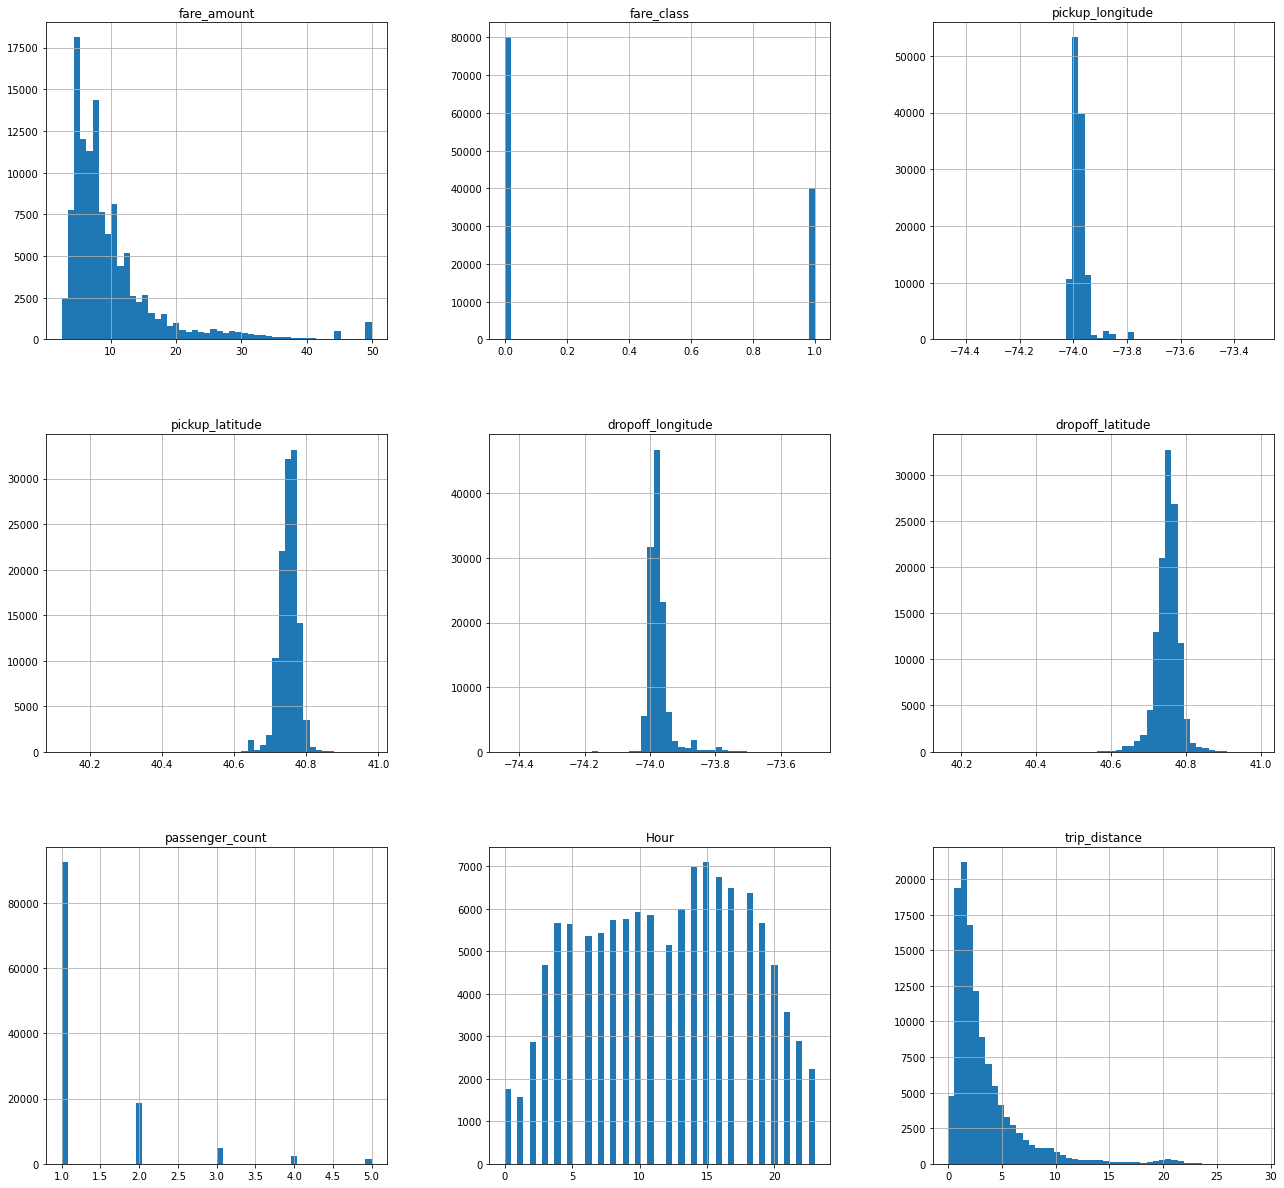

In [15]:
df.hist(figsize=(22,21), bins=50);

- We found that the "fare_amount" column have an outlier values  that may affect the model 
- We should drop the outliers and keep the fare values above 0 and below 40
- the busiest hour during the day is 4 pm.

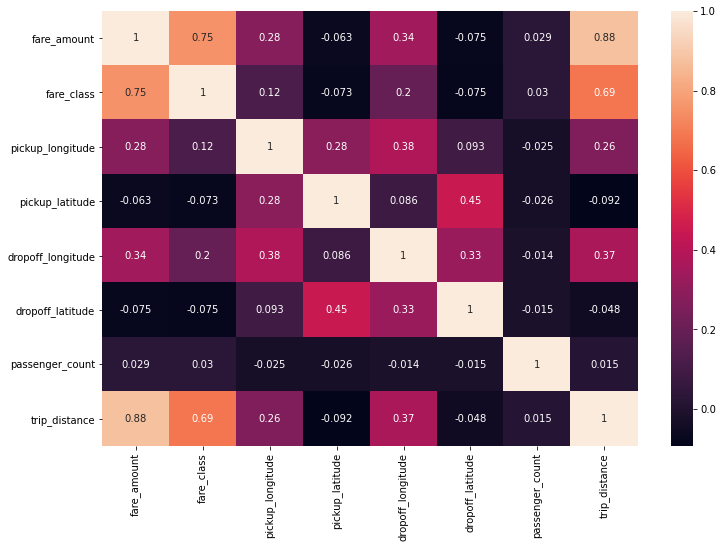

In [87]:
#Heatmap of the correlation between the columns in the dataset with annotations
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot= True)
plt.show()

- There is a high correlation between **fare_amount** and **trip_distance**  ==> corr = 0.9.
- There is a high correlation between **fare_amount** and **fare_class**  ==> corr = 0.69.
- There is a high correlation between **fare_class** and **trip_distance**  ==> corr = 0.64.

<AxesSubplot:xlabel='fare_class', ylabel='fare_amount'>

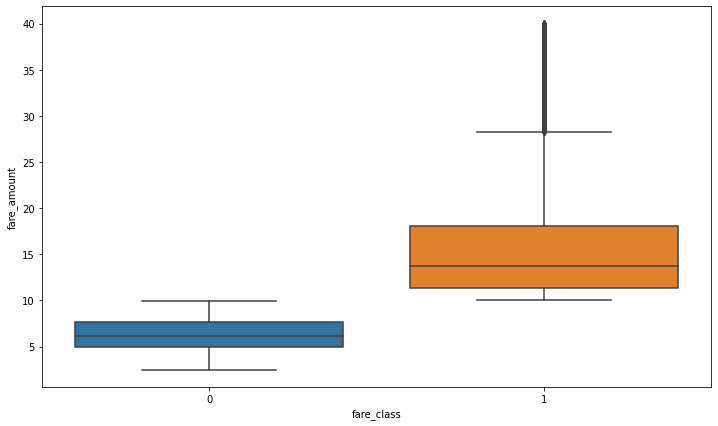

In [88]:
plt.figure(figsize=(12 , 7))

sns.boxplot(x='fare_class' , y='fare_amount' , data= df)

- We have found that if the **fare_amount** is less than 10 dollars, then the **fare_class** would be 0 *AND* if the **fare_amount** is more than 10 dollars, then the **fare_class** would be 1.

In [89]:
# Dropping the rows containing outlier **fare_amount** values
df = df[(df['fare_amount'] >= 1.) & (df['fare_amount'] <= 40.)]

- we have dropped 1% of all the data.

# Separate categorical from continuous columns


- we will use 6 continous columns and 3 categorical columns in training process.

In [98]:
cat_cols = ['Hour', 'AMorPM', 'Weekday'] # categorical columns

In [99]:
# continous columns
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count' ,'trip_distance']

- we will not use fare_class column as we won't make a classification model instead we will make a regression model, so we will use the fare_amount column instead.

In [100]:
# Output column
y_col = ['fare_amount']

In [101]:
df.dtypes

fare_amount           float64
fare_class              int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count         int64
Hour                 category
Weekday              category
trip_distance         float64
AMorPM               category
dtype: object

In [102]:
# for loop to convert the data type of the categorical columns to **category** data type
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [103]:
df.dtypes

fare_amount           float64
fare_class              int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count         int64
Hour                 category
Weekday              category
trip_distance         float64
AMorPM               category
dtype: object

In [104]:
cats = np.stack([df[col].cat.codes for col in cat_cols], axis=1) 
cats = torch.tensor(cats,dtype=torch.int64)
cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])

1- **df[col].cat.codes** => assign dummy data of each column in an array of list 

2- Convert continuous variables to a Float tensor to be more accurate values

3- Join a sequence of arrays along a new axis , sequence of array_like Each array must have the **same shape**
 
4- Convert categorical variables to a tensor

In [105]:
# in another way we do the same steps of converting continuous variables to array then join it in stack
conts = np.stack([df[col].values for col in cont_cols], axis=1) 
conts = torch.tensor(conts, dtype = torch.float)  # Convert continuous variables to a Float tensor to be more accurate values

In [106]:
conts

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1250],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3914],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3247],
        ...,
        [ 40.7498, -73.9886,  40.7078, -74.0115,   3.0000,   5.0494],
        [ 40.7245, -74.0044,  40.7308, -73.9927,   1.0000,   1.2082],
        [ 40.7719, -73.9554,  40.7630, -73.9676,   3.0000,   1.4265]])

In [107]:
#Convert Output column **fare_amount** to a Float tensor to be more accurate values
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1) #We have provided column as 1 but rows as unknown
# i want to do reshape with one column (fare_amount) but with unkown number of rows so i specified -1 in rows

In [108]:
# define the number(length) of categories in each column in categorical columns 
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
cat_szs

[24, 2, 7]

# Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2 and can be changed, but not to exceed 50. 

In [109]:
# This will set embedding sizes for Hours, AMorPM and Weekdays [ // floor division.]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]  # (size+1)//2 consider the size of vector of each word in size 

In [110]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

# Categorical Embeddings
.Categorical embeddings are very similar to word embeddings which are commonly used in **NLP**.

.The basic idea is to have a **fixed-length** vector representation of each category in the column.

.**one-hot encoding** is that instead of having a sparse matrix, using **embeddings**, we get a dense matrix for each category     with similar categories having values close to each other in the embedding space

.**nn.Embedding** => This module is often used to store word embeddings and retrieve them using indices.The input to the module is      a list of indices, and the output is the correspondingword embeddings


In [111]:
#A simple lookup table(list) that stores embeddings of a fixed dictionary and size.
em = [nn.Embedding(ni,nf) for ni,nf in emb_szs]# ni: size of the dictionary of embeddings , nf: the size of each embedding vector
em

[Embedding(24, 12), Embedding(2, 1), Embedding(7, 4)]

In [112]:
selfembeds = nn.ModuleList(em) # Holds submodules in a list

In [113]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [114]:
# FORWARD METHOD (cats)
embeddingz = []

for i,e in enumerate(selfembeds):  # i = 0,1,2
    embeddingz.append(e(cats[:,i]))

In [115]:
embeddingz

[tensor([[ 0.4955,  1.5808, -0.8403,  ..., -0.2899,  0.6970, -0.7475],
         [-0.3037, -0.2741, -0.6289,  ..., -1.4074,  1.4221, -1.2426],
         [-0.5015,  1.2622, -0.2445,  ..., -1.1859, -0.2568,  0.0948],
         ...,
         [-1.8649,  0.4643, -1.0442,  ...,  1.3783,  0.1788, -0.4794],
         [ 0.4955,  1.5808, -0.8403,  ..., -0.2899,  0.6970, -0.7475],
         [-0.2965, -1.2221,  1.1662,  ..., -0.6398,  0.6668, -0.8419]],
        grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.1432],
         [ 1.1432],
         [ 1.1432],
         ...,
         [-0.1014],
         [ 1.1432],
         [-0.1014]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.1708,  1.4291,  1.9396,  0.5575],
         [-1.2788,  0.3359, -0.7115,  1.0314],
         [-1.2788,  0.3359, -0.7115,  1.0314],
         ...,
         [ 0.0981,  0.1508,  0.6982, -1.4365],
         [ 1.2616, -0.8479,  1.1029, -1.6366],
         [-1.2788,  0.3359, -0.7115,  1.0314]], grad_fn=<EmbeddingBackward0>)]

In [116]:
## We concatenate the embedding sections (12,1,4) into one (17)
## concat the categorical data in one list
z = torch.cat(embeddingz , 1) 

In [117]:
z

tensor([[ 0.4955,  1.5808, -0.8403,  ...,  1.4291,  1.9396,  0.5575],
        [-0.3037, -0.2741, -0.6289,  ...,  0.3359, -0.7115,  1.0314],
        [-0.5015,  1.2622, -0.2445,  ...,  0.3359, -0.7115,  1.0314],
        ...,
        [-1.8649,  0.4643, -1.0442,  ...,  0.1508,  0.6982, -1.4365],
        [ 0.4955,  1.5808, -0.8403,  ..., -0.8479,  1.1029, -1.6366],
        [-0.2965, -1.2221,  1.1662,  ...,  0.3359, -0.7115,  1.0314]],
       grad_fn=<CatBackward0>)

In [118]:
# During training, randomly zeroes some of the elements of the input tensor with probability 'p' using samples from a Bernoulli
# distribution. the outputs are scaled by a factor of 1/(1-p) during training.  
selfembdrop = nn.Dropout(0.4)  
selfembdrop

Dropout(p=0.4, inplace=False)

In [119]:
z = selfembdrop(z)

In [120]:
z 

tensor([[ 0.0000,  0.0000, -0.0000,  ...,  2.3819,  0.0000,  0.9291],
        [-0.0000, -0.4568, -0.0000,  ...,  0.0000, -1.1858,  1.7191],
        [-0.0000,  2.1037, -0.0000,  ...,  0.0000, -1.1858,  0.0000],
        ...,
        [-0.0000,  0.7738, -0.0000,  ...,  0.0000,  1.1637, -2.3942],
        [ 0.0000,  2.6346, -1.4006,  ..., -1.4132,  1.8382, -0.0000],
        [-0.4942, -2.0368,  1.9437,  ...,  0.5599, -0.0000,  0.0000]],
       grad_fn=<MulBackward0>)

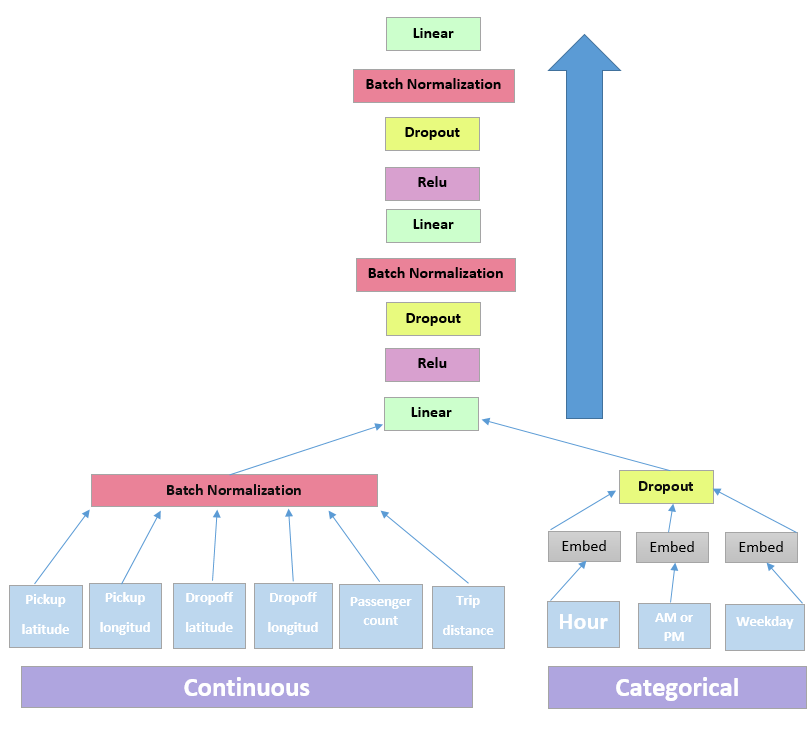

# ANN MODEL

In [121]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) #  Can be indexed like a regular Python list
        self.emb_drop = nn.Dropout(p) # Drop roundom values 
        self.bn_cont = nn.BatchNorm1d(n_cont) # normalization for ex [0 ,1]
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [122]:
torch.manual_seed(32)
model = TabularModel(emb_szs, conts.shape[1],1,[200,100],p=0.5)

In [123]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [124]:
criterion = nn.MSELoss()  # np.sqrt(MSE --> RMSE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [125]:
batch_size = 60000
test_size = int(batch_size*0.2)

In [126]:
# DATA SHUFFLED ALREADY

cat_train = cats[:batch_size-test_size] # all data to batch_size-test_size  (60000 - 12000) => 48000 record
cat_test = cats[batch_size-test_size:batch_size] # 12000 record
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [127]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [128]:
print(len(cat_train))
print(len(con_train))
print(len(y_train))

48000
48000
48000


In [129]:
print(len(cat_test))
print(len(con_test))
print(len(y_test))

12000
12000
12000


In [80]:
import time

start_time = time.time()

epoch = 400
losses = []

for i in range(1, epoch+1):
    
    y_pred = model(cat_train,con_train) # Call Forward method in class
    loss = torch.sqrt(criterion(y_pred,y_train))  # np.sqrt(MSE --> RMSE)
    losses.append(loss.detach().numpy()) # convert to numpy then appeand to be able to plot it 
    
    if i%25 == 0:
        print(f'epoch: {i} loss is {loss}')
        
    optimizer.zero_grad()  # look where the grad is min, since we we want the min point (gradient descent)
    loss.backward()
    optimizer.step()  # step back through neurons
    
duration = time.time() - start_time
print(f'Training took {duration/60} minutes')

epoch: 25 loss is 9.994227409362793
epoch: 50 loss is 9.565500259399414
epoch: 75 loss is 9.187529563903809
epoch: 100 loss is 8.620903015136719
epoch: 125 loss is 7.748589992523193
epoch: 150 loss is 6.618377208709717
epoch: 175 loss is 5.367107391357422
epoch: 200 loss is 4.259912490844727
epoch: 225 loss is 3.6606831550598145
epoch: 250 loss is 3.466951847076416
epoch: 275 loss is 3.3591859340667725
epoch: 300 loss is 3.2414212226867676
epoch: 325 loss is 3.198140859603882
epoch: 350 loss is 3.108447790145874
epoch: 375 loss is 3.06982159614563
epoch: 400 loss is 3.020530939102173
Training took 5.989217527707418 minutes


Text(0, 0.5, 'Losses')

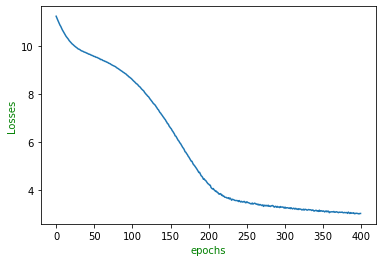

In [81]:
plt.plot(range(epoch),losses)
    
plt.xlabel("epochs" , color='green')
plt.ylabel("Losses", color='green')

In [82]:
with torch.no_grad():
    
    y_val = model(cat_test,con_test)
    
    loss = torch.sqrt(criterion(y_val,y_test))

In [83]:
loss

tensor(2.9627)

In [84]:
for i in range(15):
    diff = np.abs(y_val[i].item() - y_test[i].item())
    print(f'{i}.) Predicted: {y_val[i].item():8.2f} True: {y_test[i].item():8.2f} Difference:{diff}')

0.) Predicted:     5.03 True:     4.90 Difference:0.1335773468017578
1.) Predicted:     5.66 True:     4.50 Difference:1.1609134674072266
2.) Predicted:     4.77 True:     4.50 Difference:0.26691532135009766
3.) Predicted:     6.36 True:     3.70 Difference:2.658893346786499
4.) Predicted:     7.24 True:     8.90 Difference:1.6638898849487305
5.) Predicted:    14.49 True:    14.90 Difference:0.4149646759033203
6.) Predicted:     9.32 True:     7.70 Difference:1.6196165084838867
7.) Predicted:     8.26 True:     8.50 Difference:0.2363424301147461
8.) Predicted:    10.56 True:    11.70 Difference:1.1419696807861328
9.) Predicted:     4.37 True:     6.10 Difference:1.733644962310791
10.) Predicted:     2.95 True:     4.10 Difference:1.1481826305389404
11.) Predicted:    18.40 True:    13.70 Difference:4.702242851257324
12.) Predicted:     5.79 True:     8.50 Difference:2.706178665161133
13.) Predicted:     5.43 True:     7.30 Difference:1.8679208755493164
14.) Predicted:     5.59 True:   

In [96]:
#create data
data = [["1", 'fare_amount Before delete outliers',96.3975],
        ["2", 'fare_amount After delete outliers',96.9485],
        ["3", 'epochs incresses to 400',97.1884],
        ["4", 'longitude & latitude Drop',96.9085]]

#define header names
col_names = ["Try Num", "Try","Accuracy %"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


╒═══════════╤════════════════════════════════════╤══════════════╕
│   Try Num │ Try                                │   Accuracy % │
╞═══════════╪════════════════════════════════════╪══════════════╡
│         1 │ fare_amount Before delete outliers │      96.3975 │
├───────────┼────────────────────────────────────┼──────────────┤
│         2 │ fare_amount After delete outliers  │      96.9485 │
├───────────┼────────────────────────────────────┼──────────────┤
│         3 │ epochs incresses to 400            │      97.1884 │
├───────────┼────────────────────────────────────┼──────────────┤
│         4 │ longitude & latitude Drop          │      96.9085 │
╘═══════════╧════════════════════════════════════╧══════════════╛


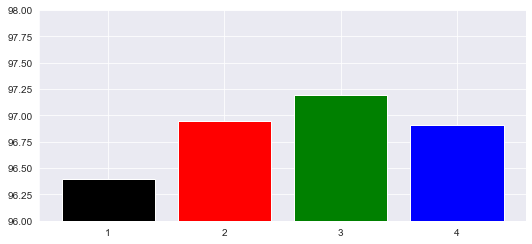

In [97]:
from matplotlib import pyplot as plt
sns.set_style('darkgrid')


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
x = ['1', '2', '3','4']
y = [96.3975, 96.9485, 97.1884 , 96.9085]

plt.ylim(96, 98)
plt.bar(x, y ,color=['black', 'red', 'green', 'blue'])
plt.show()